# Импорт библиотек и настройки

In [102]:
import re

import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import category_encoders as ce

# Построение модели 
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import train_test_split  # Загружаем специальный инструмент для разбивки:  

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

Настройка

In [103]:
RANDOM_SEED = 42

Функции

In [104]:
def draw_boxplot(
    df,
    col,
    title,
    xlabel,
    ylabel='Распределение оценки',
    size=[10,5],
    ylim=[2,10],
    rotation=0):
    '''
    Рисует sns.bloxplot 
    '''
    fig, ax = plt.subplots(figsize=(size[0], size[1]))
    sns.boxplot(df, y='reviewer_score', x=col, showmeans=True, orient='v',meanprops={'marker': '.','markeredgecolor':'black','markerfacecolor':'white'})
    ax.set(xlabel=xlabel,ylabel=ylabel)
    ax.set_title(title)
    ax.set_ylim(ylim[0], ylim[1])
    ax.yaxis.grid(True)
    plt.xticks(rotation=rotation)


In [105]:
def reduce_categories_number(df:pd.DataFrame, col:str, n:int) -> pd.DataFrame:
    """Оставляет n самых часто встречающихся значений, остальные помечает как Other

    Args:
        df (pd.DataFrame): Входные данные
        col (str): Столбец который изменяем
        n (int): Количество значений после преобразования

    Returns:
        pd.DataFrame: Измененные данные
    """    
    popular_values = df[col].value_counts().nlargest(n).index
    df[col] = df[col].apply(lambda x: x if x in popular_values else 'Other')
    return df

In [106]:
def encode(df:pd.DataFrame, col:str) -> pd.DataFrame:
    """OneHotEncoder column 

    Args:
        df (pd.DataFrame): Входные данные
        column (str): Какой столбец кодировать

    Returns:
        pd.DataFrame: Измененные данные
    """      
    
    one_hot_encoder = ce.OneHotEncoder(cols=col, use_cat_names=True)
    encoded = one_hot_encoder.fit_transform(df[col])
    
    df = pd.concat([df, encoded], axis=1, join='inner')
    
    return df

# Постановка задача

Нужно создать модель для предсказания рейтинга отеля.

# Загрузка и очистка данных
![Alt text](image-1.png)

In [107]:
df = pd.read_csv('data/hotels.csv')

## ydata

In [108]:
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile

In [ ]:
ProfileReport()

In [109]:
#profile.to_file('data/hotels_report.html')

## Очистка данных

### Null значения

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Есть 2 столбца с пропусками lat и lng. Обработаем их позже когда будет признак country

### Дубликаты

In [111]:
# Удаляем дубликаты
df = df.drop_duplicates()
df.shape

(386496, 17)

# EDA

## Проектирование признаков

### Разбираем признак tags

#### tags_list

Тот же самый признак, но тэги хранятся в виде списка

In [112]:
df['tags_list'] = df['tags'].apply(lambda s: s[3:-3].split(" ', ' "))
df['tags_list'].head()

0    [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1    [Business trip, Couple, Standard Double Room, ...
2    [Leisure trip, Solo traveler, Modern Double Ro...
3    [Leisure trip, Solo traveler, Standard Room wi...
4    [Business trip, Couple, Standard Double or Twi...
Name: tags_list, dtype: object

#### tags_count

Кол-во тэгов

In [113]:
df['tags_count'] = df['tags_list'].apply(len)
df['tags_count'].value_counts()

tags_count
5    223293
4    158448
3      4122
6       563
2        65
1         5
Name: count, dtype: int64

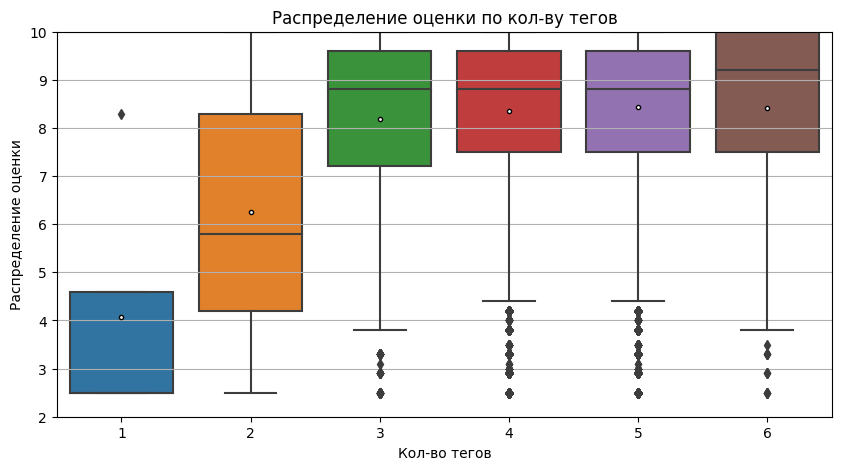

In [114]:
draw_boxplot(df,'tags_count','Распределение оценки по кол-ву тегов','Кол-во тегов')

#### Посмотрим на тэги

In [115]:
# Делаем датафрейм тегов и их количества в исходных данных
tags_dict = {}
for tag in [item for sublist in df['tags_list'] for item in sublist]:
    if tag in tags_dict:
        tags_dict[tag] += 1
    else:
        tags_dict[tag] = 1
tags_df = pd.DataFrame(tags_dict,index=['count']).transpose().reset_index()
tags_df = tags_df.rename(columns={'index':'tag'})
tags_df.sort_values(by='count', ascending=False,inplace=True)

In [116]:
tags_df.head(15)

,tag,count
0,Leisure trip,313353
4,Submitted from a mobile device,230608
1,Couple,189046
7,Stayed 1 night,145296
3,Stayed 2 nights,100176
8,Solo traveler,81166
10,Stayed 3 nights,71940
5,Business trip,61934
25,Group,49057
20,Family with young children,45810


#### leisure_type

Признак показывающий была ли поездка отдыхом

In [117]:
def get_trip_type(tags_list):
    for element in tags_list:
        if 'Leisure trip' in element:
            return 1
    return 0
df['leisure_type'] = df['tags_list'].apply(get_trip_type)
df['leisure_type'].value_counts()

leisure_type
1    313353
0     73143
Name: count, dtype: int64

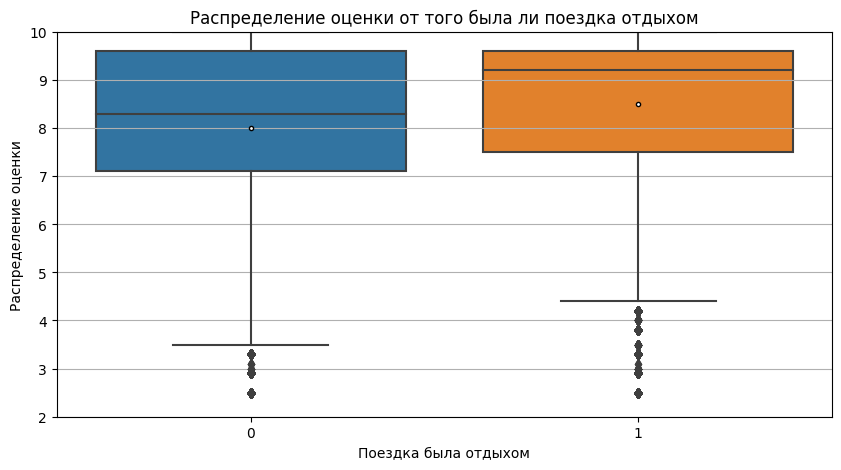

In [118]:
draw_boxplot(df,'leisure_type','Распределение оценки от того была ли поездка отдыхом','Поездка была отдыхом')

#### travell_type

Тип путешествия: Один, с семьей, парой и прочее

In [119]:
travell_type = ['Couple','Family with young children','Solo','Travelers with friends']
def get_travell_type(tags_list):
    for element in tags_list:
        for travell in travell_type:
            if travell in element:
                return element
    return 'Other'
df['travell_type'] = df['tags_list'].apply(get_travell_type)
df['travell_type'].value_counts()

travell_type
Couple                        189046
Solo traveler                  81166
Other                          68844
Family with young children     45810
Travelers with friends          1630
Name: count, dtype: int64

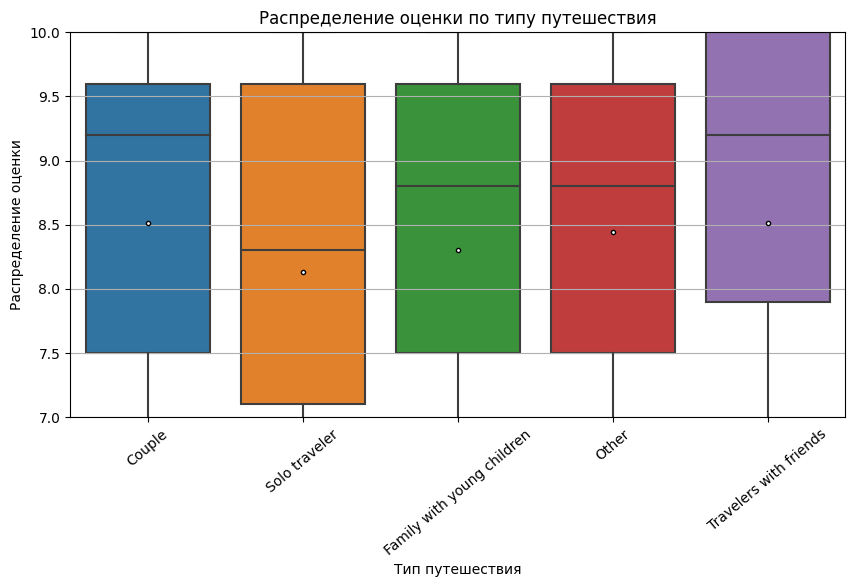

In [120]:
draw_boxplot(df,'travell_type','Распределение оценки по типу путешествия','Тип путешествия',ylim=[7,10],rotation=40)

#### room_type

Тип снятый комнаты

In [121]:
# Список чтобы поймать почти все нужные тэги
rooms_list = ['Deluxe','Double','Room','rooms','Suite','King','Twin','Standard','Superior','Apartment','Studio']
def get_room_type(tags_list):
    for element in tags_list: # Цикл по тэгам
        for room_type in rooms_list: # Цикл по элементам в списке
            if room_type in element: # Если элемент есть в тэге
                if room_type == 'rooms': # Объединяем тэги со словом rooms в один
                    return 'Rooms'
                return element
    return 'None'
df['room_type'] = df['tags_list'].apply(get_room_type)
df['room_type'].value_counts()[:15]

room_type
Double Room                     26386
Standard Double Room            24150
Superior Double Room            23518
Deluxe Double Room              18612
Double or Twin Room             16824
Standard Double or Twin Room    13058
Classic Double Room             12604
Superior Double or Twin Room    10238
Rooms                            9701
Standard Twin Room               7325
Single Room                      7225
Twin Room                        6278
Executive Double Room            4763
Classic Double or Twin Room      4569
Superior Twin Room               4530
Name: count, dtype: int64

#### with_window

Была ли комната с окном

In [122]:
# Смотрим все теги где встречается слово окно
df[df['room_type'].str.contains('indow')]['room_type'].value_counts()

room_type
Standard Double Room without Window               1808
Standard Double Room No Window                     348
Deluxe Double Room without Window                   28
Small Double Room without Window                    23
Economy Single Room basement no window              22
Economy Double Room basement no window              15
Comfort Single Room with Window and Double Bed      14
Suite without Window                                 6
Name: count, dtype: int64

In [123]:
def room_have_window(arg:str) -> int:
    if 'without window' in arg.lower() or 'no window' in arg.lower():
        return 0
    else:
        return 1
df['with_window'] = df['room_type'].apply(room_have_window)
df['with_window'].value_counts()

with_window
1    384246
0      2250
Name: count, dtype: int64

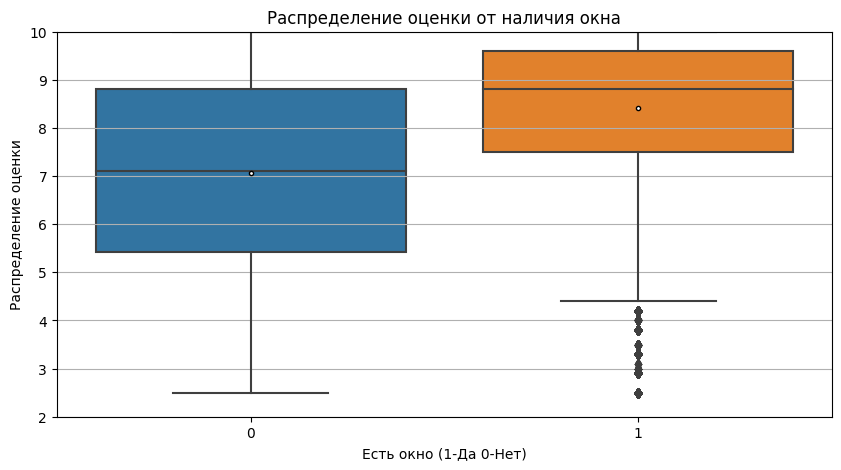

In [124]:
draw_boxplot(df,'with_window','Распределение оценки от наличия окна','Есть окно (1-Да 0-Нет)')

#### may_smoking

Можно ли было курить в комнате

In [125]:
# Смотрим все теги где есть слово курить
df[df['room_type'].str.contains('moking')]['room_type'].value_counts().head(5)

room_type
Double Room Non Smoking                  977
Queen Room Non Smoking                   526
Twin Room Non Smoking                    509
Double or Twin Room Non Smoking          394
Double Room with Sofa Bed Non Smoking    224
Name: count, dtype: int64

In [126]:
def get_non_smoking(arg:str) -> int:
    if 'non smoking' in arg.lower() or 'no window' in arg.lower():
        return 0
    else:
        return 1
df['may_smoking'] = df['room_type'].apply(get_non_smoking)
df['may_smoking'].value_counts()

may_smoking
1    382787
0      3709
Name: count, dtype: int64

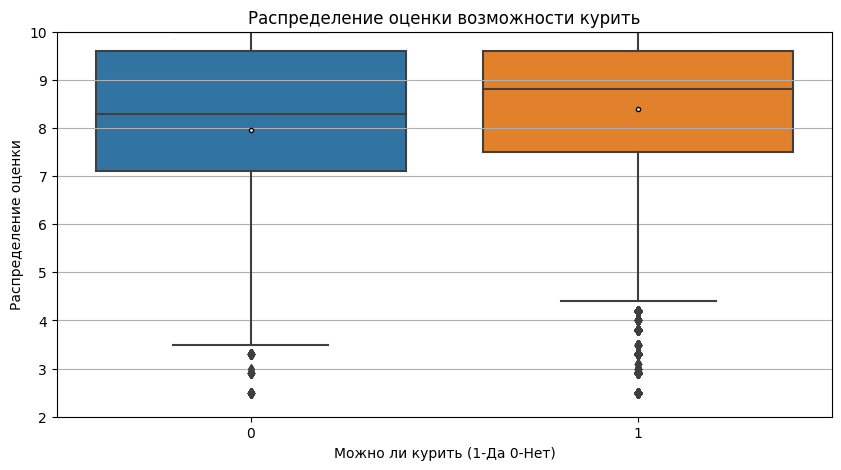

In [127]:
draw_boxplot(df,'may_smoking','Распределение оценки возможности курить','Можно ли курить (1-Да 0-Нет)')

#### stayed_nights

Количество проведённых ночей в отеле

In [128]:
def get_nights_count(tags_list):
    for element in tags_list: # Цикл по всем тэгам
            if 'Stayed' in element: # Если в тэге есть слово Stayed то значит что тэг про количество проведённых ночей
                res = re.search(r'Stayed (\d{,2})', element)
                return int(res[1])
    return 2 # Медиана, заранее её выяснил
df['stayed_nights'] = df['tags_list'].apply(get_nights_count)
df['stayed_nights'].value_counts()

stayed_nights
1     145296
2     100322
3      71940
4      35708
5      15592
6       7388
7       5541
8       1907
9        966
10       662
11       305
12       217
14       184
13       174
15        87
16        38
17        27
18        24
19        23
21        19
20        17
30        10
27        10
22         8
28         7
23         6
26         6
24         5
25         4
29         3
Name: count, dtype: int64

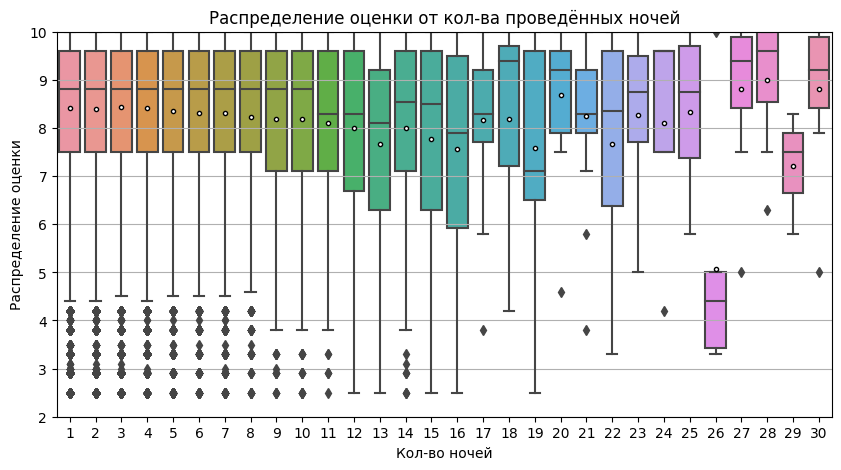

In [129]:
draw_boxplot(df,'stayed_nights','Распределение оценки от кол-ва проведённых ночей','Кол-во ночей')

При большом количестве ночей оценка сильно скачет, связанно это с тем что данных крайне мало при таких значениях

#### mobile_submit

Был ли выложен отзыв при помощи телефона

In [130]:
def get_mobile_submit(arg):
    if 'Submitted from a mobile device' in arg:
        return 1
    return 0
df['mobile_submit'] = df['tags'].apply(get_mobile_submit)
df['mobile_submit'].value_counts()

mobile_submit
1    230608
0    155888
Name: count, dtype: int64

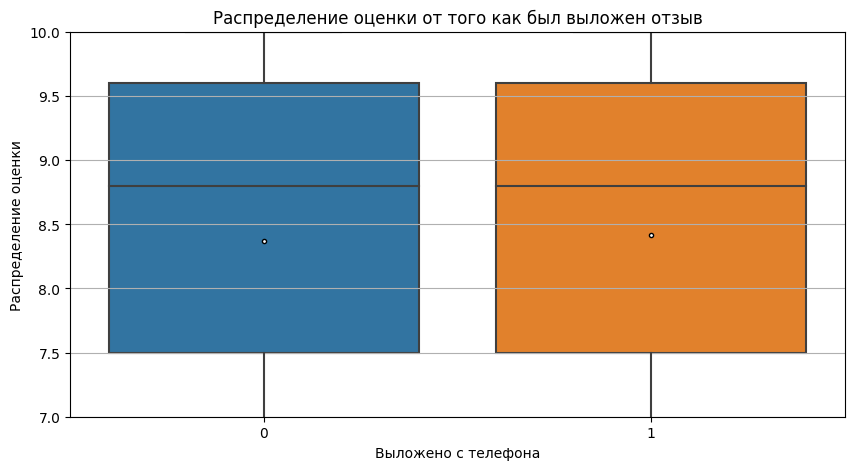

In [131]:
draw_boxplot(df,'mobile_submit','Распределение оценки от того как был выложен отзыв','Выложено с телефона',ylim=[7,10])

Почему то на графике разница нулевая, но в дальнейшем тест показывает что признак имеет значение в модели

### Разбираем признак review_data

Создаем 3 новых признака: Год, месяц и день недели того когда был выложен отзыв

In [132]:
df['review_date'] = pd.to_datetime(df['review_date'])

df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month
df['weekday'] = df['review_date'].dt.weekday + 1

df = df.drop('review_date', axis=1)

#### year

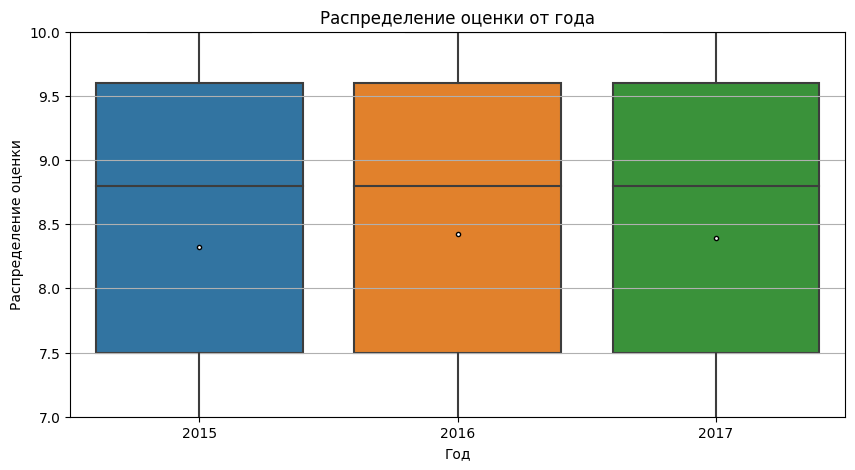

In [133]:
draw_boxplot(df,'year','Распределение оценки от года','Год',ylim=[7,10])

#### month

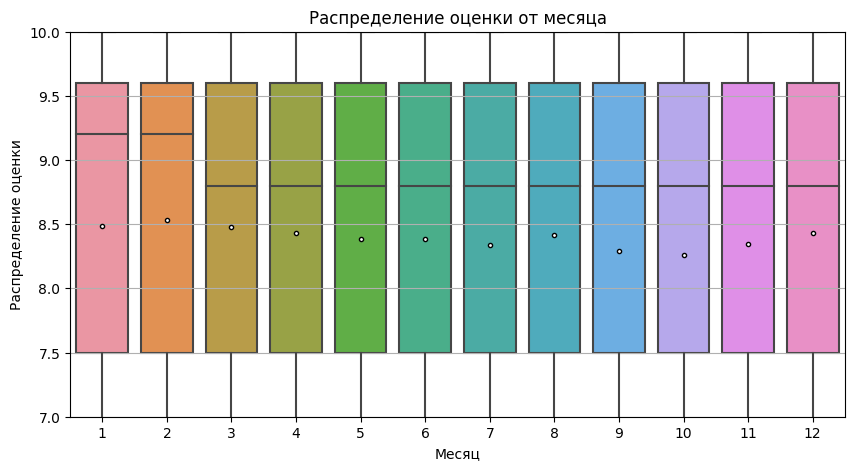

In [134]:
draw_boxplot(df,'month','Распределение оценки от месяца','Месяц',ylim=[7,10])

#### weekday

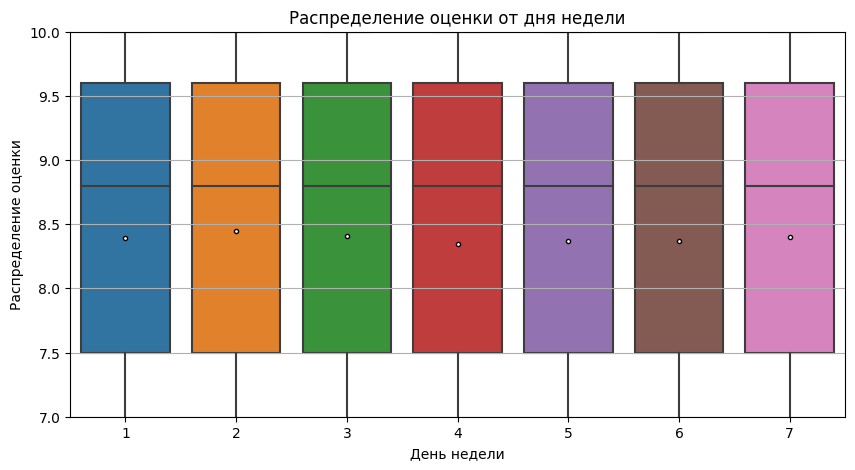

In [135]:
draw_boxplot(df,'weekday','Распределение оценки от дня недели','День недели',ylim=[7,10])

### Разбираем признак hotel_address

In [136]:
df['hotel_address'].describe()

count                                                386496
unique                                                 1493
top       163 Marsh Wall Docklands Tower Hamlets London ...
freq                                                   3587
Name: hotel_address, dtype: object

#### hotel_country

Страна в которой находится отель

In [137]:
def get_country(arg:str) -> str:
    return arg.split()[-1]

df['hotel_country'] = df['hotel_address'].apply(get_country)
df['hotel_country'].value_counts()

hotel_country
Kingdom        196773
Spain           45132
France          44528
Netherlands     43004
Austria         29177
Italy           27882
Name: count, dtype: int64

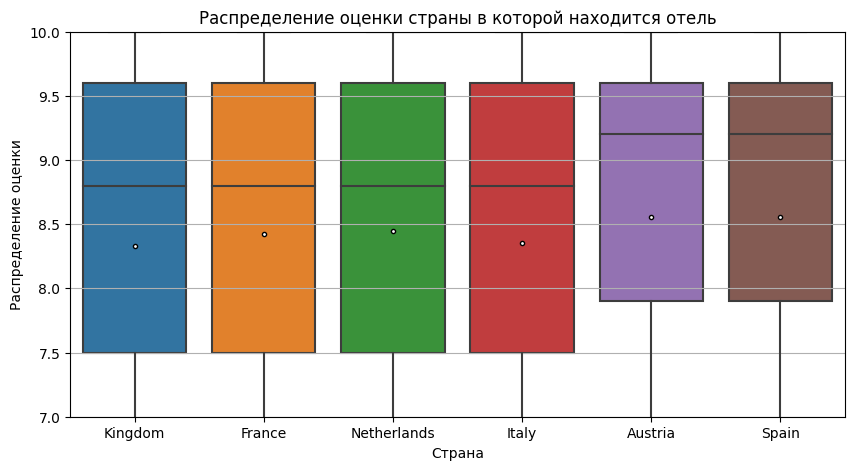

In [138]:
draw_boxplot(df,'hotel_country','Распределение оценки страны в которой находится отель','Страна',ylim=[7,10])

### Прочее

#### word_ratio

Соотношение положительных и негативных слов

In [139]:
df['word_ratio'] = df.apply(lambda x: x['review_total_positive_word_counts']/(x['review_total_negative_word_counts']+1), axis=1)
df['word_ratio'].value_counts()

word_ratio
0.000000    26863
1.000000     8960
0.500000     6336
2.000000     6184
0.666667     5926
            ...  
1.426230        1
0.015306        1
0.250951        1
4.730769        1
5.965517        1
Name: count, Length: 9882, dtype: int64

#### country_matches

Совпадают ли страна отеля со страной ревьювера

In [140]:
df['country_matches'] = df.apply(lambda x: 1 if x['hotel_country'] in x['reviewer_nationality'] else 0, axis=1)
df['country_matches'].value_counts()

country_matches
0    252574
1    133922
Name: count, dtype: int64

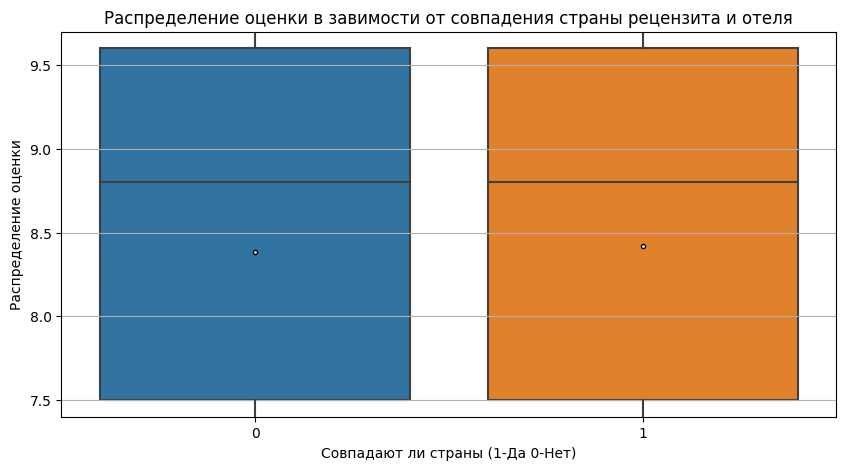

In [141]:
draw_boxplot(df,'country_matches','Распределение оценки в завимости от совпадения страны рецензита и отеля','Совпадают ли страны (1-Да 0-Нет)',ylim=[7.4,9.7])

## Преобразование признаков

In [142]:
df_backup = df.copy()

### _word_counts

Изменил верхнюю границу чтобы корреляция с рейтингом была больше

In [143]:
df['review_total_negative_word_counts'] = df['review_total_negative_word_counts'].apply(lambda x: 40 if x > 40 else x)
df['review_total_positive_word_counts'] = df['review_total_positive_word_counts'].apply(lambda x: 12 if x > 12 else x)

### reviewer_nationality

Уменьшаем кол-во категорий до 10

In [144]:
df = reduce_categories_number(df,'reviewer_nationality',10)
df['reviewer_nationality'].value_counts()

reviewer_nationality
 United Kingdom               183952
Other                         109369
 United States of America      26494
 Australia                     16216
 Ireland                       11119
 United Arab Emirates           7612
 Saudi Arabia                   6716
 Netherlands                    6598
 Switzerland                    6492
 Canada                         5977
 Germany                        5951
Name: count, dtype: int64

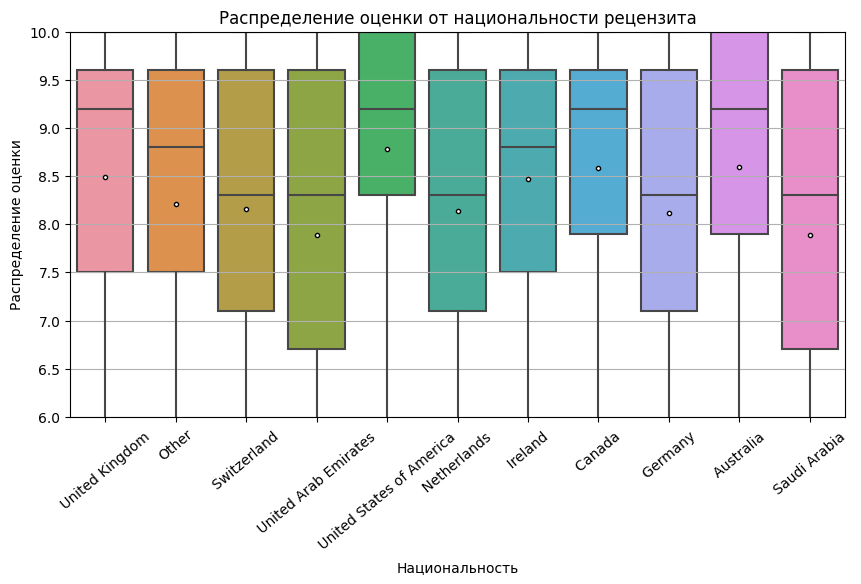

In [145]:
draw_boxplot(df,'reviewer_nationality','Распределение оценки от национальности рецензита','Национальность',rotation=40,ylim=[6,10])

### room_type

Уменьшаем кол-во категорий до 7

In [146]:
df = reduce_categories_number(df,'room_type',7)
df['room_type'].value_counts()

room_type
Other                           251344
Double Room                      26386
Standard Double Room             24150
Superior Double Room             23518
Deluxe Double Room               18612
Double or Twin Room              16824
Standard Double or Twin Room     13058
Classic Double Room              12604
Name: count, dtype: int64

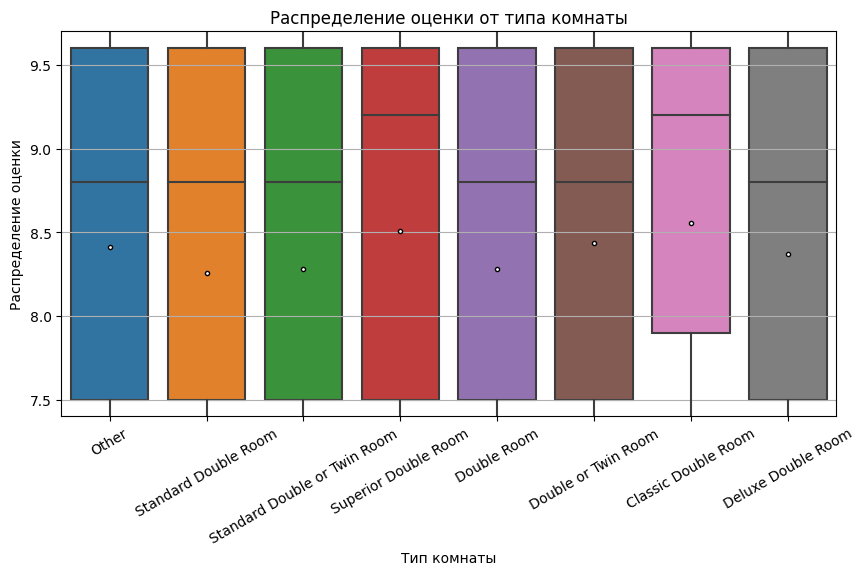

In [147]:
draw_boxplot(df,'room_type','Распределение оценки от типа комнаты','Тип комнаты',rotation=30,ylim=[7.4,9.7])

### stayed_nights

Уменьшаем кол-во категорий до 9, также оставляем этот признак как числовой

In [148]:
df = reduce_categories_number(df,'stayed_nights',9)
df['stayed_nights'] = df['stayed_nights'].apply(lambda x: 9 if x == 'Other' else x)
df['stayed_nights'].value_counts()

stayed_nights
1    145296
2    100322
3     71940
4     35708
5     15592
6      7388
7      5541
9      2802
8      1907
Name: count, dtype: int64

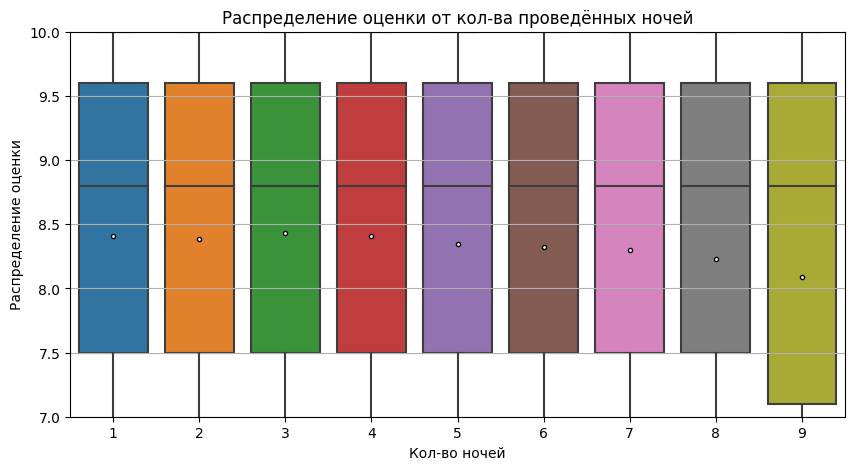

In [149]:
draw_boxplot(df,'stayed_nights','Распределение оценки от кол-ва проведённых ночей','Кол-во ночей',ylim=[7,10])

### days_since_review

Преобразуем тип столбца в число

In [150]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x.split()[0]))
df['days_since_review']

0         531
1         203
2         289
3         681
4         516
         ... 
386798    106
386799    171
386800    543
386801     74
386802    363
Name: days_since_review, Length: 386496, dtype: int64

### lat lng

Избавляемся от пропусков и преобразуем чтобы не было отрицательных значений

In [151]:
# Пропуски есть только в 3 странах
df[df['lat'].isnull()]['hotel_country'].value_counts()

hotel_country
Austria    1990
France      299
Spain       159
Name: count, dtype: int64

In [152]:
# Вставим в пропущенные значения медиану для соответствующей страны
values_lat = {
    'Austria': df[df['hotel_country'] == 'Austria']['lat'].median(),
    'France': df[df['hotel_country'] == 'France']['lat'].median(),
    'Spain': df[df['hotel_country'] == 'Spain']['lat'].median(),}
values_lng = {
    'Austria': df[df['hotel_country'] == 'Austria']['lng'].median(),
    'France': df[df['hotel_country'] == 'France']['lng'].median(),
    'Spain': df[df['hotel_country'] == 'Spain']['lng'].median(),}
df['lat'] = df.apply(lambda x: values_lat[x['hotel_country']] if np.isnan(x['lat']) else x['lat'], axis = 1)
df['lng'] = df.apply(lambda x: values_lng[x['hotel_country']] if np.isnan(x['lng']) else x['lng'], axis = 1)

In [153]:
df[['lat','lng']].isnull().value_counts()

lat    lng  
False  False    386496
Name: count, dtype: int64

In [154]:
# Убираем отрицательные числа, а также изменяем масштаб на от 0 до 1
df['lat'] = df['lat'].apply(lambda x: (x+90)/180)
df['lng'] = df['lng'].apply(lambda x: (x+180)/360)

In [155]:
df[['lat','lng']]

,lat,lng
0,0.786155,0.499601
1,0.786228,0.499658
2,0.771363,0.506460
3,0.771604,0.506652
4,0.791031,0.513464
...,...,...
386798,0.786078,0.499469
386799,0.767735,0.545554
386800,0.786227,0.499636
386801,0.786195,0.499555


## Кодирование признаков

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   average_score                               386496 non-null  float64
 3   hotel_name                                  386496 non-null  object 
 4   reviewer_nationality                        386496 non-null  object 
 5   negative_review                             386496 non-null  object 
 6   review_total_negative_word_counts           386496 non-null  int64  
 7   total_number_of_reviews                     386496 non-null  int64  
 8   positive_review                             386496 non-null  object 
 9   review_total_positive_word_counts           386496 non-null  int64  
 10  t

In [157]:
df_backup = df.copy()

In [158]:
df = df_backup.copy()

In [159]:
# Список признаков которые закодируем OneHotEncoder
encode_list = ['travell_type','hotel_country','room_type','reviewer_nationality']
for elem in encode_list:
    df = encode(df, elem)
    df = df.drop(elem,axis=1)
df.columns

Index(['hotel_address', 'additional_number_of_scoring', 'average_score',
       'hotel_name', 'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'tags_list', 'tags_count',
       'leisure_type', 'with_window', 'may_smoking', 'stayed_nights',
       'mobile_submit', 'year', 'month', 'weekday', 'word_ratio',
       'country_matches', 'travell_type_Couple', 'travell_type_Solo traveler',
       'travell_type_Family with young children', 'travell_type_Other',
       'travell_type_Travelers with friends', 'hotel_country_Kingdom',
       'hotel_country_France', 'hotel_country_Netherlands',
       'hotel_country_Italy', 'hotel_country_Austria', 'hotel_country_Spain',
       'room_type_Other', 'room_type_Standard Double Room',
       'room_type_Standard Double or Twin Room',


## Отбор признаков

In [160]:
# Удаляем все нечисловые признаки
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 51 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     386496 non-null  int64  
 1   average_score                                    386496 non-null  float64
 2   review_total_negative_word_counts                386496 non-null  int64  
 3   total_number_of_reviews                          386496 non-null  int64  
 4   review_total_positive_word_counts                386496 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given       386496 non-null  int64  
 6   reviewer_score                                   386496 non-null  float64
 7   days_since_review                                386496 non-null  int64  
 8   lat                                              386496 non-null  float64
 9   lng                 

In [162]:
df.nunique()

additional_number_of_scoring                        480
average_score                                        34
review_total_negative_word_counts                    40
total_number_of_reviews                            1142
review_total_positive_word_counts                    12
total_number_of_reviews_reviewer_has_given          194
reviewer_score                                       37
days_since_review                                   731
lat                                                1472
lng                                                1472
tags_count                                            6
leisure_type                                          2
with_window                                           2
may_smoking                                           2
stayed_nights                                         9
mobile_submit                                         2
year                                                  3
month                                           

### Выделим категориальные и числовые признаки

In [163]:
num_cols = ['additional_number_of_scoring',
            'average_score',
            'review_total_negative_word_counts',
            'review_total_positive_word_counts',
            'total_number_of_reviews',
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review',
            'stayed_nights',
            'word_ratio']
cat_cols = ['lat',
            'lng',
            'tags_count',
            'leisure_type',
            'mobile_submit',
            'country_matches',
            'year',
            'month',
            'weekday',]
# Добавляем все закодированные признаки в список с категориальными столбцами
for elem in encode_list:
    cat_cols.extend(list(filter(lambda col: col if elem in col else None, df.columns)))

### Проверяем на мультиколлинеарность

#### Числовые признаки

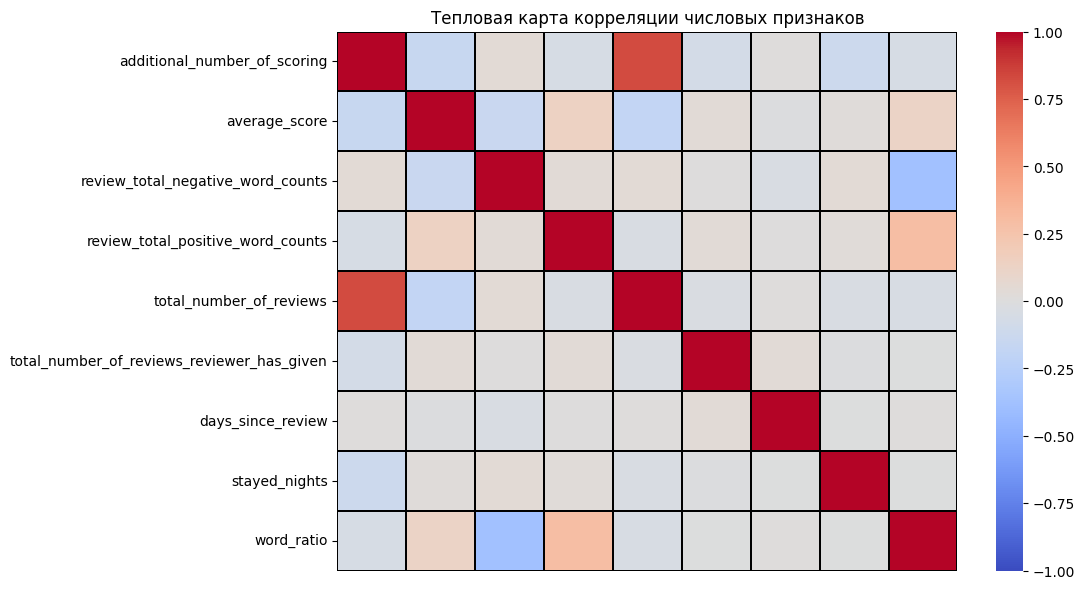

In [164]:
fig, ax = plt.subplots(1,1,figsize=[10,7])
sns.heatmap(data = df[num_cols].corr(method='pearson'),
            vmin=-1, vmax=1, center=0,cmap= 'coolwarm',linewidths=0.2, linecolor='black',xticklabels=False, ax=ax)
ax.set_title('Тепловая карта корреляции числовых признаков');

#### Категориальные признаки

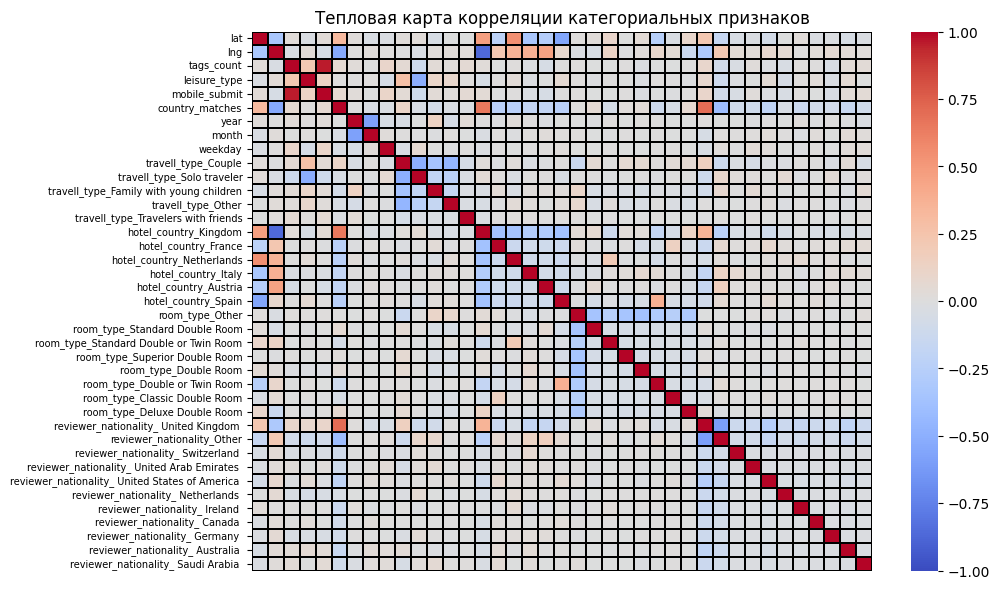

In [165]:
fig, ax = plt.subplots(1,1,figsize=[10,7])
ax.tick_params(axis='y', labelsize=7)
sns.heatmap(data = df[cat_cols].corr(method='spearman'),
            vmin=-1, vmax=1, center=0,cmap= 'coolwarm',linewidths=0.2, linecolor='black',xticklabels=False, ax=ax)
ax.set_title('Тепловая карта корреляции категориальных признаков');

#### Удаляем признаки с мультиколлинеарностью

In [166]:
# Получаем датафрейм признаков с корреляцией больше чем 0.7
corr = df.corr().abs().unstack().reset_index() 
corr = corr[( corr[0] > 0.7) & (corr['level_0'] != corr['level_1'])]
# Убираем из дф все повторения чтобы удалить всего один признак из двух коррелирующих
dup_list = []
def check_duplicates(row):
    if row['level_0'] not in dup_list:
        dup_list.append(row['level_1'])
        return True
    else:
        return False
mask = corr.apply(check_duplicates,axis=1)

In [167]:
cols_drop = list(corr[mask]['level_0'].values)
cols_drop

['additional_number_of_scoring',
 'days_since_review',
 'lat',
 'lng',
 'tags_count',
 'country_matches']

### Оценим значимость признаков

#### Числовые признаки

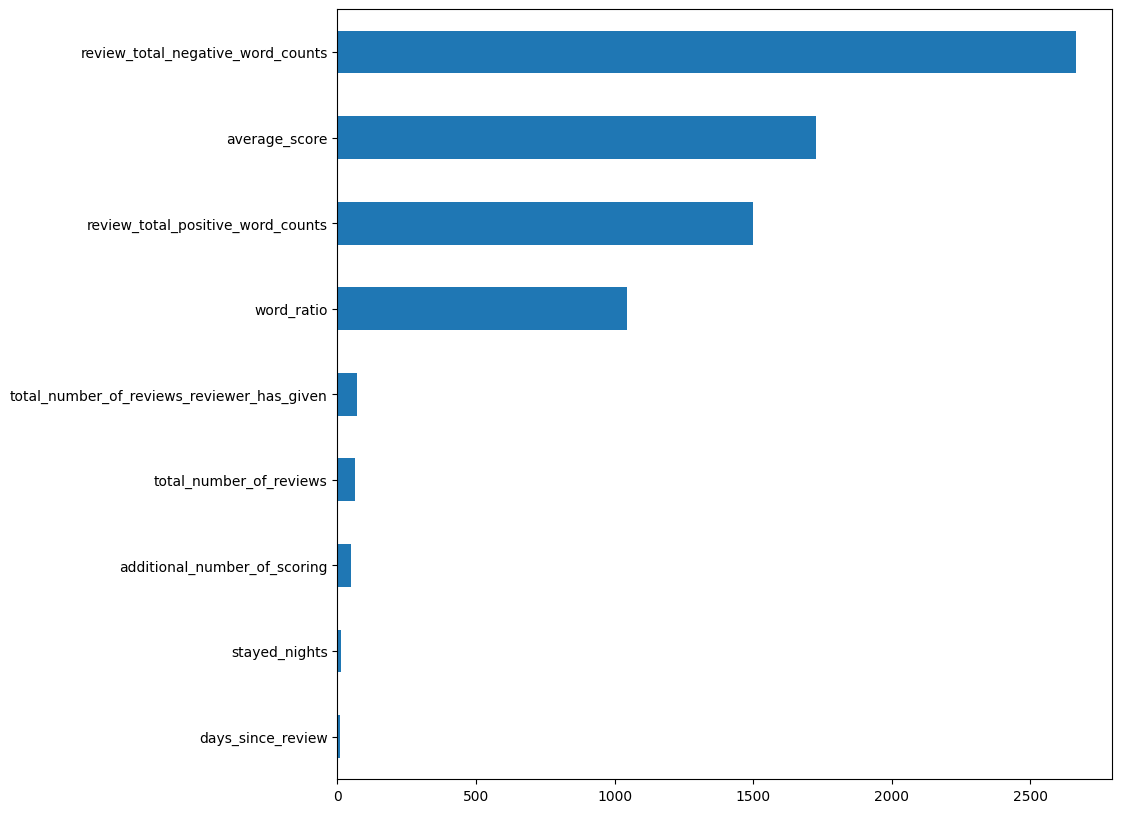

In [168]:
imp_num = pd.Series(f_classif(df[num_cols], df['reviewer_score'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

In [169]:
# Удалим все признаки значимость которых менее 20
cols_drop.extend(list(imp_num[imp_num<20].index))
cols_drop

['additional_number_of_scoring',
 'days_since_review',
 'lat',
 'lng',
 'tags_count',
 'country_matches',
 'days_since_review',
 'stayed_nights']

#### Категориальные признаки

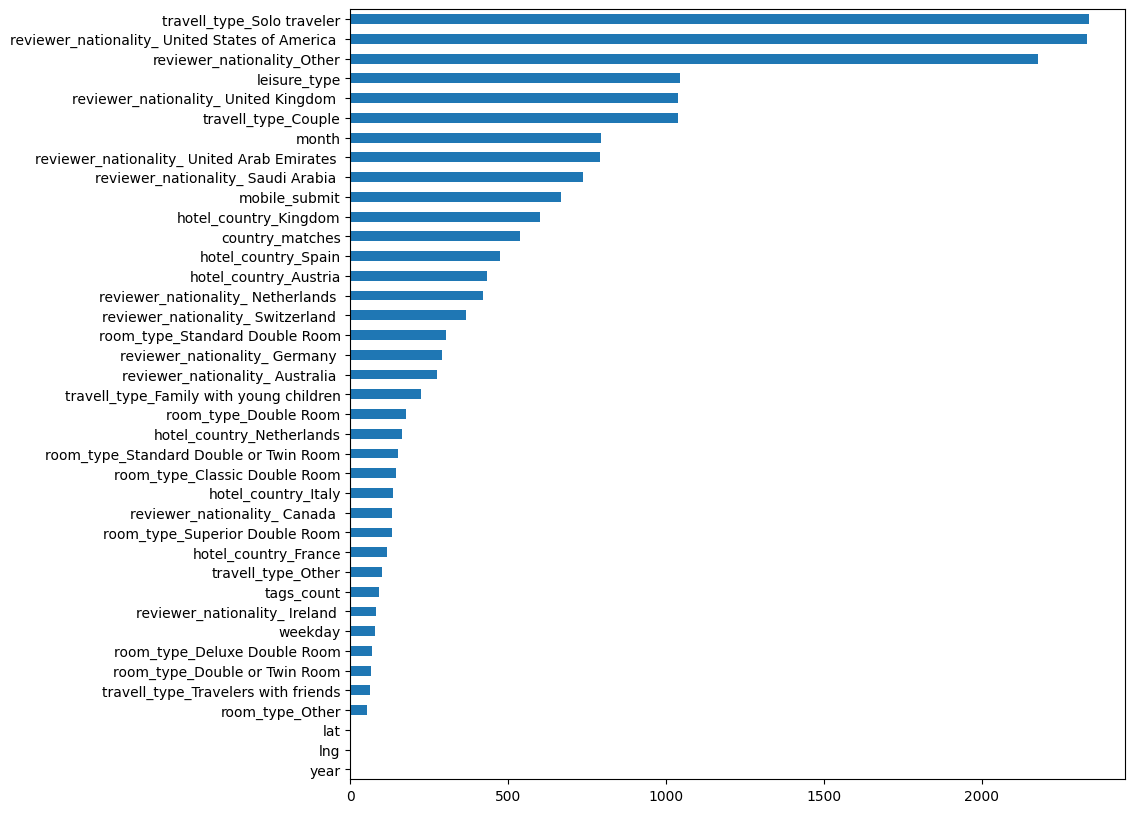

In [170]:
imp_num = pd.Series(chi2(df[cat_cols], 10*df['reviewer_score'])[0], index = cat_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

In [171]:
# Удалим все признаки значимость которых менее 20
cols_drop.extend(list(imp_num[imp_num<20].index))
# Убираем повторения
cols_drop = list(set(cols_drop))
cols_drop

['year',
 'tags_count',
 'lat',
 'stayed_nights',
 'lng',
 'country_matches',
 'additional_number_of_scoring',
 'days_since_review']

### Удаляем признаки

In [172]:
df = df.drop(cols_drop,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 43 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   average_score                                    386496 non-null  float64
 1   review_total_negative_word_counts                386496 non-null  int64  
 2   total_number_of_reviews                          386496 non-null  int64  
 3   review_total_positive_word_counts                386496 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given       386496 non-null  int64  
 5   reviewer_score                                   386496 non-null  float64
 6   leisure_type                                     386496 non-null  int64  
 7   with_window                                      386496 non-null  int64  
 8   may_smoking                                      386496 non-null  int64  
 9   mobile_submit       

## Построение и проверка гипотез

# Создаем модель

In [173]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим

object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

# заполняем пропуски самым простым способом
df = df.fillna(0)

In [174]:
df

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,leisure_type,with_window,may_smoking,mobile_submit,...,reviewer_nationality_Other,reviewer_nationality_ Switzerland,reviewer_nationality_ United Arab Emirates,reviewer_nationality_ United States of America,reviewer_nationality_ Netherlands,reviewer_nationality_ Ireland,reviewer_nationality_ Canada,reviewer_nationality_ Germany,reviewer_nationality_ Australia,reviewer_nationality_ Saudi Arabia
0,8.4,3,1994,4,7,10.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,8.3,3,1361,2,14,6.3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,8.9,6,406,0,14,7.5,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,7.5,0,607,11,8,10.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,8.5,4,7586,12,10,9.6,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9.0,0,617,10,10,8.8,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
386799,8.4,0,3224,12,1,9.2,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
386800,6.8,12,2751,9,21,8.3,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
386801,8.1,0,1567,6,28,9.2,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0


<Axes: >

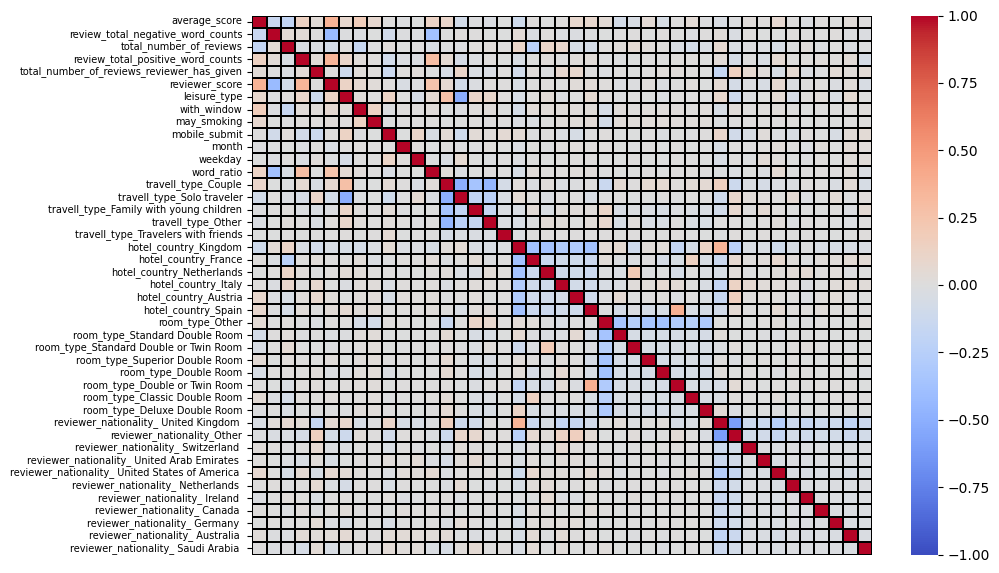

In [175]:
fig, ax = plt.subplots(1,1,figsize=[10,7])
ax.tick_params(axis='both', labelsize=7)
sns.heatmap(data = df.corr(),
            vmin=-1, vmax=1, center=0,cmap= 'coolwarm',linewidths=0.2, linecolor='black',xticklabels=False, ax=ax)

In [176]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = df.drop(['reviewer_score'], axis = 1)  
y = df['reviewer_score'] 

In [177]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [178]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100,random_state=RANDOM_SEED)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [182]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13557278009191792


In [180]:
# 1  MAPE: 0.143
# 2  MAPE: 0.142055
# 3  MAPE: 0.141383
# 4  MAPE: 0.140164
# 5  MAPE: 0.141680
# 6  MAPE: 0.138381
#    Добавил кат. признак pos_more показывающий больше ли слов в положительном отзыве чем в отрицательном
# 7  MAPE: 0.135572
#    Изменил признак pos_more на word_ratio показывающий соотношение кол-во слов в положительном отзыве к кол-ву слов в отрицательном

### Влияние признаков в модели

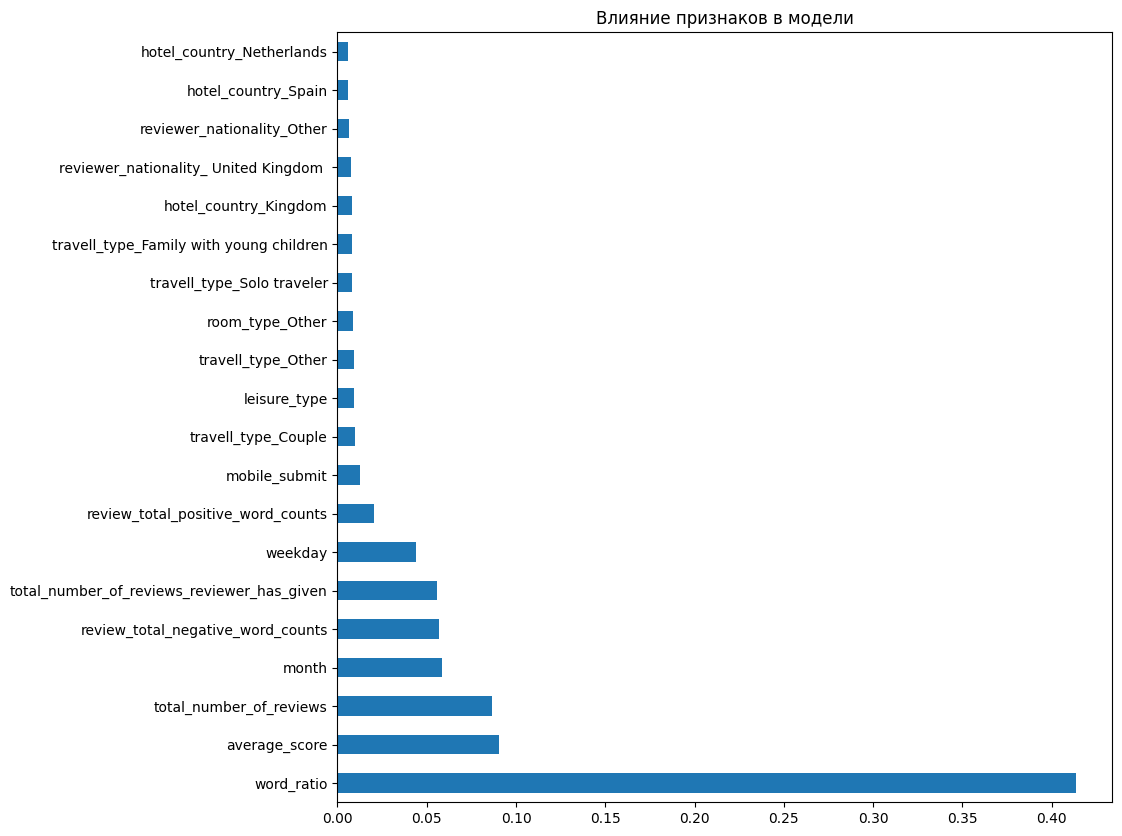

In [181]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Влияние признаков в модели');